# 阅读维基百科来回答开放领域的问题

陈丹琦

斯坦福大学计算机科学

斯坦福，美国CA 94305

danqi@cs.stanford.edu


亚当·菲什，杰森·韦斯顿和安东尼·博尔德斯

Facebook AI 研究 770 百老汇

纽约，纽约10003，美国

{afisch,jase,abordes}@fb.com

# 摘要
本文提出利用维基百科作为唯一的知识来源来解决开放领域的问答:任何事实性问题的答案都是维基百科文章中的一个文本跨度。大规模的机器阅读任务结合了文档检索(查找相关文章)和机器文本理解(从这些文章中确定答案)的挑战。我们的方法结合了一个基于双图哈希和TF-IDF匹配的搜索组件和一个多层递归神经网络模型，该模型训练用于检测Wikipedia段落中的答案。我们在多个现有QA数据集上的实验表明，(1)这两个模块相对于现有的同类模块具有很强的竞争力，(2)使用远程监控它们的组合进行多任务学习是完成这一具有挑战性任务的有效的完整系统。



# 1介绍
本文以维基百科为唯一的知识来源，在开放的领域环境下，如在百科全书中寻找答案时，考虑了如何回答真人真事的问题。维基百科是一个不断进化的详细信息来源，如果智能机器能够利用它的力量，它可以为智能机器提供便利。与Freebase或DBPedia等知识库不同，Wikipedia包含了人类感兴趣的最新知识。然而，它是为人类而不是机器而设计的。

利用维基百科的文章作为知识来源，使得问答(QA)的任务结合了大规模开放领域QA和文本机器理解的挑战。要回答任何问题，首先必须从500多万篇文章中检索出几篇相关文章，然后仔细扫描，以确定答案。我们称这种设置为“按比例机器阅读”(MRS)。我们的工作将Wikipedia视为一个文章集合，不依赖于它的内部图结构。因此，我们的方法是通用的，可以切换到其他文档、书籍甚至每日更新的报纸集合。

像IBM的DeepQA这样的大型QA系统依赖于多个源来回答问题:除了Wikipedia，它还与KBs、字典、甚至新闻文章、书籍等相匹配。因此，这类系统严重依赖源之间的信息冗余来正确回答。拥有一个单一的知识来源迫使模型在搜索答案时非常精确，因为证据可能只出现一次。因此，这一挑战包括对机器阅读能力的研究、机器理解子领域的关键动机以及创建数据集(如SQuAD、CNN/Daily Mail和CBT)。

然而，这些机器理解资源通常假定已经标识了一小段相关的文本并将其提供给模型，这对于构建开放领域的QA系统是不现实的。与此形成鲜明对比的是，对文档使用KBs或信息检索的方法必须将搜索作为解决方案的一个组成部分。相反，MRS专注于同时保持机器理解的挑战，这需要对文本的深刻理解，同时保持在大型开放资源上搜索的现实约束。

在本文中，我们展示了如何使用多个现有的QA数据集来评估MRS，方法是要求一个开放域系统同时对所有这些数据集执行良好。我们开发DrQA,一个强大的系统组成的从维基百科问答:(1)文档检索,一个模块使用三元散列和TF-IDF匹配设计,给出一个问题,有效地返回一个子集的相关文章和(2)文档阅读器,多层机器理解递归神经网络模型训练检测答案横跨在少数返回文档。图1给出了DrQA的说明。

我们的实验表明，文档检索器的性能优于内置的Wikipedia搜索引擎，并且文档阅读器在非常具有竞争力的阵容基准上达到了最先进的结果。最后，使用多个基准对整个系统进行评估。我们特别指出，与单任务训练相比，通过使用多任务学习和远程监控，所有数据集的性能都得到了提高。

# 2相关工作
开放域QA最初的定义是在每年的TREC竞赛之后，在非结构化文档集合中寻找答案。随着KBs的发展，许多最近的创新都发生在KBs的QA上下文中，这些创新创建了基于Freebase 知识库的WebQuestions和SimpleQuestions等资源，或者基于自动提取的KBs，例如OpenIE triples和NELL。然而，KBs有固有的局限性(不完整、固定的模式)，这促使研究人员返回到原始文本的原始回答设置。

重新审视这一问题的第二个动机是机器对文本的理解，即，阅读一篇短文或故事后回答问题。领域已经取得了相当大的进步最近由于新的深度学习架构以注意力和记忆增强神经网络和释放新的训练和评估数据集,例如QuizBowl, CNN /每日邮报基于新闻文章,CBT基于儿童书籍,或小组和WikiReading基于维基百科。本文的目标是测试这些新方法如何在开放领域QA框架中执行。

使用Wikipedia作为资源的QA以前已经被探索过。Ryu等人(2014)使用基于wiki的知识模型执行开放域QA。它们将文章内容与基于不同类型的半结构化知识(如信息框、文章结构、类别结构和定义)的多个其他答案匹配模块相结合。类似地，Ahn还将Wikipedia作为文本资源与其他资源相结合，在本例中是与其他文档的信息检索相结合。Buscaldi和Rosso(2006)也从Wikipedia中为QA挖掘知识。他们不把它用作寻找问题答案的资源，而是专注于验证QA系统返回的答案，并使用Wikipedia分类确定一组应该与预期答案相匹配的模式。在我们的工作中，我们只考虑对文本的理解，并使用Wikipedia文本文档作为唯一的资源，以强调机器大规模阅读的任务，如引言所述。

有许多高度开发的完整管道QA方法使用Web(如QuASE)或Wikipedia(如微软的AskMSR、IBM的DeepQA和YodaQA)作为资源——后者是开放源码的，因此可以重复使用，以便进行比较。AskMSR是一个基于搜索引擎的QA系统，它依赖于“数据冗余，而不是对问题或候选答案进行复杂的语言分析”。，它不像我们那样关注机器理解。DeepQA是一个非常复杂的系统，它既依赖于非结构化信息(包括文本文档)，也依赖于结构化数据(如KBs、数据库和本体)来生成候选答案或对证据进行投票。YodaQA是一个模仿DeepQA的开源系统，类似地结合了网站、信息提取、数据库，特别是Wikipedia。只有使用单一的资源，我们的理解任务才更具挑战性。与这些方法相比，为性能的“上限”基准测试提供了一个有用的数据点。

多任务学习和任务迁移在机器学习(例如，在计算机视觉社区中使用ImageNet)，特别是在NLP中有着悠久的历史。有几项工作尝试通过多任务学习来组合多个QA培训数据集，以(i)通过任务转移实现跨数据集的改进;(ii)由于源数据集中不可避免地存在不同的数据分布，因此提供一个能够询问不同类型问题的单一通用系统。Fader等(2014)使用WebQuestions、TREC和WikiAnswers作为知识来源，共4个KBs，并通过多任务学习对后两个数据集进行了改进。Bordes et al.(2015)将WebQuestions和SimpleQuestions结合起来，使用远程监控和Freebase作为知识库，对两个数据集都进行了轻微的改进，尽管只有一个数据集上的培训和另一个数据集上的测试的性能较差，但这表明任务转移确实是一个具有挑战性的主题;另见类似的结论。我们的工作遵循类似的主题，但是在必须检索并读取文本文档的情况下，而不是使用KB，结果是积极的。

# 3我们的系统:DrQA
在下面，我们描述了我们的DrQA for MRS系统，它由两个组件组成:(1)用于查找相关文章的文档检索模块(Document Retriever module)和(2)用于从单个文档或少量文档集合中提取答案的机器理解模型(Document Reader)。

## 3.1文档检索
遵循经典的QA系统，我们使用一个高效的(非机器学习)文档检索系统，首先缩小搜索空间，只阅读可能相关的文章。与内置的基于弹性搜索的Wikipedia搜索API相比，一个简单的反向索引查找，然后是术语向量模型评分，在许多问题类型上都能很好地完成这项任务。将文章和问题作为TF-IDF加权词包向量进行比较。我们进一步完善了我们的系统，考虑到本地语序使用n-gram特征。我们性能最好的系统使用双图计数，同时通过使用散列将双图映射到2的24次方个带有无符号murmur3散列的箱子，从而保持速度和内存效率。

我们使用Document Retriever作为完整模型的第一部分，将其设置为返回给定问题的5篇Wikipedia文章。然后由文档阅读器处理这些文章。

## 3.2文档的读者
我们的文档阅读器模型的灵感来自最近神经网络模型在机器理解任务上的成功，这与赫尔曼中描述的AttentiveReader的精神类似。

给一个由L个词{q1，…，ql}组成的问题q，和一个由n个段落组成的文档或一小组文档，其中一个段落p由m个词{p1,...,pm}组成。，我们开发了一个RNN模型，我们依次应用于每个段落，然后最终聚合预测的答案。我们的方法如下:

### 段编码:
我们首先表征所有的词pi在一个段落p，序列的特征向量并将其作为输入传递给递归神经网络，得到:

{p1,p2,..,pm}=RNN({p1-,...,pm-}),

pi期望编码成词pi周围的有用上下文信息。具体来说，我们选择使用多层双向长短时记忆网络(LSTM)，最后以pi作为各层隐藏单元的串联。

特征向量p˜由以下部分组成:

词嵌入:
femb(pi) = E(pi)。我们使用被840B网爬数据训练的300维Glove字嵌入。我们保留了大部分预训练词嵌入，嵌入层被固定，并且只微调了1000个最常见的问题单词，因为一些关键单词的表示形式，例如什么、如何、哪些，其中许多对于QA系统可能是至关重要的。

精确匹配:
准确匹配(pi) = I(pi).我们使用三个简单的二进制特性，表示pi是否可以精确匹配q中的一个问题单词，无论是原始的、小写的还是引证的形式。这些简单的特性非常有用，我们将在第5节中介绍。

词的特点:
ftoken(pi) = (POS(pi)， NER(pi)， TF(pi))。我们还添加了一些手动特性，这些特性反映了令牌pi的一些特性，包括它的词性(POS)和命名实体识别(NER)标签以及它的(标准化)词频(TF)。

嵌入对齐的问题:
接下来和其他近期的工作中，我们纳入的最后一部分是一个对齐的嵌入问题falign(pi)，其中注意分值ai,j捕捉pi和每个uestion words qj之间的相似性。其中ai,j由词嵌入的非线性映射之间的点积计算得到:
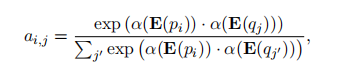
和α()是一个与ReLU非线性全连接层。与精确匹配特性相比，这些特性在相似但不相同的单词(如car和vehicle)之间添加了软对齐。

问题编码： 
问题编码更简单，因为我们只在qi的嵌入词上应用另一个递归神经网络，并将产生的隐藏单元合并成一个向量:{q1，…ql}->q，我们计算q = Sigmaj(bjqj)，其中bj对每个疑问词的重要性进行编码:
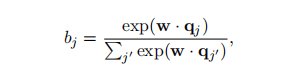
W是一个权重向量，需要学习的。

预测：
在段落级别，目标是预测最可能是正确答案的标记的范围。我们取段落向量{p1，…，pm}和问题向量q作为输入，并简单地分别训练两个分类器来预测跨度的两端。具体来说，我们使用双线性项来捕捉pi和q之间的相似性，并计算每个词开始和结束的概率为:
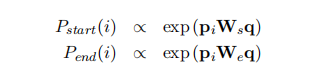

在预测过程中，我们选取词i到令牌i'的最佳张成空间，令i≤i'≤i + 15，使Pstart(i)×Pend(i')最大化。为了使一个或多个检索到的文档的段落之间的分数兼容，我们使用非标准化指数，并在所有考虑的段落跨度上使用argmax作为最终预测。






# 4数据
我们的工作依赖于三种类型的数据:(1)维基百科,作为我们的知识来源寻找答案,(2)SQuAD数据集是我们训练文档阅读器的主要资源和(3)三个QA数据集(CuratedTREC, WebQuestions和WikiMovies),除了阵容,用于测试open-domain QA全系统的能力,并评估我们的模型向多任务学习的能力学习和遥远的监督。表2给出了数据集的统计数据。